In [1]:
import pandas as pd
import numpy as np
import spacy
from dont_patronize_me2 import DontPatronizeMe
nlp = spacy.load(
    "en_core_web_lg"
)
d = DontPatronizeMe("data", "data")
d.load_task1()
df = d.train_task1_df
df.head()

,par_id,art_id,keyword,country,text,label,orig_label
0,@@23953477,in-need,in,The ones in need of constant medical care are ...,The ones in need of constant medical care are ...,0,0
1,@@4703096,immigrant,jm,NBC and Spanish-language Univision both declin...,NBC and Spanish-language Univision both declin...,0,0
2,@@25567226,in-need,hk,A second T-Home project is being launched in t...,A second T-Home project is being launched in t...,0,0
3,@@1824078,poor-families,tz,Camfed would like to see this trend reversed ....,Camfed would like to see this trend reversed ....,1,4
4,@@1921089,refugee,tz,Kagunga village was reported to lack necessary...,Kagunga village was reported to lack necessary...,0,0


In [2]:
vector_lengths = np.array([len(nlp(text)) for text in df.text.values[0:1000]])


(array([174., 462., 217.,  83.,  39.,  15.,   7.,   2.,   0.,   1.]),
 array([  4. ,  27.1,  50.2,  73.3,  96.4, 119.5, 142.6, 165.7, 188.8,
        211.9, 235. ]),
 <BarContainer object of 10 artists>)

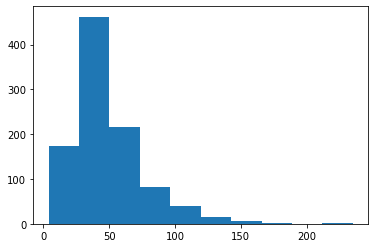

In [3]:
import matplotlib.pyplot as plt
plt.hist(vector_lengths)

In [4]:
doc = nlp("word")
doc.vector.shape

(300,)

In [2]:
seq_len = 120
def vectorize(text):
    doc = nlp(text)
    vector = np.array([token.vector for token in doc[:min(seq_len, len(doc))]])
    if len(vector.shape) != 2:
        print(text)
        return
    if len(doc) < seq_len:
        vector = np.concatenate((np.zeros((seq_len-len(doc), 300)), vector))
    return vector

In [3]:
df["vec"] = df["text"].apply(vectorize)

In [4]:
print(len(df))
df = df.dropna()
print(len(df))

10636
10635


In [5]:
df.vec[0].shape


(120, 300)

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=197)

for train_index, test_index in sss.split(df['vec'], df['label']):
    X_train, X_test = df.vec.iloc[train_index], df.vec.iloc[test_index]
    y_train, y_test = df.label.iloc[train_index], df.label.iloc[test_index]
    
    X_train = np.stack(X_train.values)
    X_test = np.stack(X_test.values)
    
    X_val = X_train[:X_train.shape[0] // 10,:,:]
    X_train = X_train[X_train.shape[0] // 10 : ,:,:]
    
    y_val = y_train[:y_train.shape[0] // 10]
    y_train = y_train[y_train.shape[0] // 10 :]
    print(X_train.shape)

(7658, 120, 300)


In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.values))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val.values))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.values))

batch_size = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [9]:
device = torch.device("cpu")
import torch.nn as nn

In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size // 2,
                          num_layers=num_layers, batch_first=True, bidirectional = True, dropout = 0.5) #lstm
        
        self.dropout = nn.Dropout(0.5)
        self.h1 = nn.Linear(hidden_size * seq_length, 128)
        self.fc = nn.Linear(128, num_classes)
        #self.sigmoid = nn.Sigmoid()
    
    def forward(self,x, hidden):    
        batch_size = x.size(0)
        x = x.float()
        lstm_out, hidden = self.lstm(x, hidden)
        #print(lstm_out.shape)
        #lstm_out = lstm_out[:,-1,:] #lstm_out.contiguous().view(-1, self.hidden_size)
        lstm_out = torch.reshape(lstm_out, (batch_size, -1))
        out = self.dropout(lstm_out)
        print(out.shape)
        out = self.h1(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out, hidden
    
    def init_hidden(self, batch_size):
        return (torch.zeros(4, batch_size, self.hidden_size // 2).float(), torch.zeros(4, batch_size, self.hidden_size // 2).float())

In [11]:
learning_rate = 0.0003 #0.001 l
input_size = 300
hidden_size = 128 #number of features in hidden state
num_layers = 2 #number of stacked lstm layers

num_classes = 2 #number of output classes 

In [12]:
import torch.optim as optim
model = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train.shape[1]) #our lstm class

weight = torch.tensor([1.0, 5.0])
criterion = torch.nn.CrossEntropyLoss(weight=weight, reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
X_train.shape[1]

120

In [14]:
from tqdm import tqdm

In [15]:
torch.seed()
epochs = 5
counter = 0
clip = 5
print_every = 20
valid_loss_min = np.Inf
model = model.float()
model.train()
train_losses = []
for i in tqdm((range(epochs))):
    
    for inputs, labels in tqdm(train_loader):
        h = model.init_hidden(inputs.shape[0])
        counter += 1
        h = tuple([e.data for e in h])
        inputs, labels = inputs.to(device), labels.to(device)
        model.zero_grad()
        output, h = model(inputs, h)
        loss = criterion(output, labels)
        print(loss)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_losses.append(loss)
        #print(output.squeeze())
        #print(sum(output.float().detach().numpy()>0.5))
        
        
        if counter%print_every == 0:
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = model.init_hidden(inp.shape[0])
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(device), lab.to(device)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out, lab)
                val_losses.append(val_loss.item())
                
            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) <= valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

torch.Size([128, 15360])
tensor(0.7328, grad_fn=<NllLossBackward0>)



  2%|█▍                                                                                 | 1/60 [00:02<02:26,  2.49s/it]

torch.Size([128, 15360])
tensor(0.5555, grad_fn=<NllLossBackward0>)



  3%|██▊                                                                                | 2/60 [00:03<01:26,  1.50s/it]

torch.Size([128, 15360])
tensor(1.1891, grad_fn=<NllLossBackward0>)



  5%|████▏                                                                              | 3/60 [00:04<01:08,  1.20s/it]

torch.Size([128, 15360])
tensor(0.6477, grad_fn=<NllLossBackward0>)



  7%|█████▌                                                                             | 4/60 [00:05<01:00,  1.09s/it]

torch.Size([128, 15360])
tensor(0.6125, grad_fn=<NllLossBackward0>)



  8%|██████▉                                                                            | 5/60 [00:05<00:55,  1.01s/it]

torch.Size([128, 15360])
tensor(0.4501, grad_fn=<NllLossBackward0>)



 10%|████████▎                                                                          | 6/60 [00:06<00:53,  1.01it/s]

torch.Size([128, 15360])
tensor(0.6590, grad_fn=<NllLossBackward0>)



 12%|█████████▋                                                                         | 7/60 [00:07<00:51,  1.04it/s]

torch.Size([128, 15360])
tensor(0.6836, grad_fn=<NllLossBackward0>)



 13%|███████████                                                                        | 8/60 [00:08<00:49,  1.06it/s]

torch.Size([128, 15360])
tensor(0.6536, grad_fn=<NllLossBackward0>)



 15%|████████████▍                                                                      | 9/60 [00:09<00:46,  1.10it/s]

torch.Size([128, 15360])
tensor(0.6668, grad_fn=<NllLossBackward0>)



 17%|█████████████▋                                                                    | 10/60 [00:10<00:46,  1.08it/s]

torch.Size([128, 15360])
tensor(0.6815, grad_fn=<NllLossBackward0>)



 18%|███████████████                                                                   | 11/60 [00:11<00:47,  1.04it/s]

torch.Size([128, 15360])
tensor(0.6538, grad_fn=<NllLossBackward0>)



 20%|████████████████▍                                                                 | 12/60 [00:12<00:45,  1.05it/s]

torch.Size([128, 15360])
tensor(0.6558, grad_fn=<NllLossBackward0>)



 22%|█████████████████▊                                                                | 13/60 [00:13<00:44,  1.05it/s]

torch.Size([128, 15360])
tensor(0.6245, grad_fn=<NllLossBackward0>)



 23%|███████████████████▏                                                              | 14/60 [00:14<00:45,  1.01it/s]

torch.Size([128, 15360])
tensor(0.5714, grad_fn=<NllLossBackward0>)



 25%|████████████████████▌                                                             | 15/60 [00:15<00:46,  1.03s/it]

torch.Size([128, 15360])
tensor(0.6640, grad_fn=<NllLossBackward0>)



 27%|█████████████████████▊                                                            | 16/60 [00:16<00:43,  1.02it/s]

torch.Size([128, 15360])
tensor(0.6693, grad_fn=<NllLossBackward0>)



 28%|███████████████████████▏                                                          | 17/60 [00:17<00:39,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5523, grad_fn=<NllLossBackward0>)



 30%|████████████████████████▌                                                         | 18/60 [00:18<00:39,  1.06it/s]

torch.Size([128, 15360])
tensor(0.5104, grad_fn=<NllLossBackward0>)



 32%|█████████████████████████▉                                                        | 19/60 [00:19<00:38,  1.07it/s]

torch.Size([128, 15360])
tensor(0.6343, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])


torch.Size([82, 15360])
Epoch: 1/5... Step: 20... Loss: 0.634258... Val Loss: 0.640683
Validation loss decreased (inf --> 0.640683).  Saving model ...


 33%|███████████████████████████▎                                                      | 20/60 [00:24<01:34,  2.37s/it]

torch.Size([128, 15360])
tensor(0.6690, grad_fn=<NllLossBackward0>)



 35%|████████████████████████████▋                                                     | 21/60 [00:25<01:14,  1.91s/it]

torch.Size([128, 15360])
tensor(0.7245, grad_fn=<NllLossBackward0>)



 37%|██████████████████████████████                                                    | 22/60 [00:26<01:02,  1.63s/it]

torch.Size([128, 15360])
tensor(0.5915, grad_fn=<NllLossBackward0>)



 38%|███████████████████████████████▍                                                  | 23/60 [00:27<00:51,  1.40s/it]

torch.Size([128, 15360])
tensor(0.7113, grad_fn=<NllLossBackward0>)



 40%|████████████████████████████████▊                                                 | 24/60 [00:28<00:44,  1.24s/it]

torch.Size([128, 15360])
tensor(0.6059, grad_fn=<NllLossBackward0>)



 42%|██████████████████████████████████▏                                               | 25/60 [00:29<00:39,  1.14s/it]

torch.Size([128, 15360])
tensor(0.6097, grad_fn=<NllLossBackward0>)



 43%|███████████████████████████████████▌                                              | 26/60 [00:30<00:35,  1.05s/it]

torch.Size([128, 15360])
tensor(0.6853, grad_fn=<NllLossBackward0>)



 45%|████████████████████████████████████▉                                             | 27/60 [00:31<00:32,  1.00it/s]

torch.Size([128, 15360])
tensor(0.6479, grad_fn=<NllLossBackward0>)



 47%|██████████████████████████████████████▎                                           | 28/60 [00:31<00:30,  1.06it/s]

torch.Size([128, 15360])
tensor(0.6166, grad_fn=<NllLossBackward0>)



 48%|███████████████████████████████████████▋                                          | 29/60 [00:32<00:28,  1.09it/s]

torch.Size([128, 15360])
tensor(0.6975, grad_fn=<NllLossBackward0>)



 50%|█████████████████████████████████████████                                         | 30/60 [00:33<00:27,  1.10it/s]

torch.Size([128, 15360])
tensor(0.6014, grad_fn=<NllLossBackward0>)



 52%|██████████████████████████████████████████▎                                       | 31/60 [00:34<00:26,  1.11it/s]

torch.Size([128, 15360])
tensor(0.6562, grad_fn=<NllLossBackward0>)



 53%|███████████████████████████████████████████▋                                      | 32/60 [00:35<00:24,  1.14it/s]

torch.Size([128, 15360])
tensor(0.6137, grad_fn=<NllLossBackward0>)



 55%|█████████████████████████████████████████████                                     | 33/60 [00:36<00:23,  1.15it/s]

torch.Size([128, 15360])
tensor(0.5575, grad_fn=<NllLossBackward0>)



 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:37<00:24,  1.08it/s]

torch.Size([128, 15360])
tensor(0.6368, grad_fn=<NllLossBackward0>)



 58%|███████████████████████████████████████████████▊                                  | 35/60 [00:38<00:23,  1.04it/s]

torch.Size([128, 15360])
tensor(0.6836, grad_fn=<NllLossBackward0>)



 60%|█████████████████████████████████████████████████▏                                | 36/60 [00:39<00:22,  1.05it/s]

torch.Size([128, 15360])
tensor(0.6371, grad_fn=<NllLossBackward0>)



 62%|██████████████████████████████████████████████████▌                               | 37/60 [00:40<00:22,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5839, grad_fn=<NllLossBackward0>)



 63%|███████████████████████████████████████████████████▉                              | 38/60 [00:41<00:21,  1.01it/s]

torch.Size([128, 15360])
tensor(0.5897, grad_fn=<NllLossBackward0>)



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:42<00:21,  1.02s/it]

torch.Size([128, 15360])
tensor(0.5765, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [00:47<00:44,  2.22s/it]

torch.Size([82, 15360])
Epoch: 1/5... Step: 40... Loss: 0.576533... Val Loss: 0.594886
Validation loss decreased (0.640683 --> 0.594886).  Saving model ...
torch.Size([128, 15360])
tensor(0.6487, grad_fn=<NllLossBackward0>)



 68%|████████████████████████████████████████████████████████                          | 41/60 [00:48<00:36,  1.92s/it]

torch.Size([128, 15360])
tensor(0.6970, grad_fn=<NllLossBackward0>)



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [00:49<00:29,  1.65s/it]

torch.Size([128, 15360])
tensor(0.6066, grad_fn=<NllLossBackward0>)



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [00:50<00:24,  1.46s/it]

torch.Size([128, 15360])
tensor(0.5502, grad_fn=<NllLossBackward0>)



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [00:51<00:21,  1.33s/it]

torch.Size([128, 15360])
tensor(0.5872, grad_fn=<NllLossBackward0>)



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [00:52<00:18,  1.21s/it]

torch.Size([128, 15360])
tensor(0.6430, grad_fn=<NllLossBackward0>)



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [00:53<00:16,  1.15s/it]

torch.Size([128, 15360])
tensor(0.6772, grad_fn=<NllLossBackward0>)



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [00:54<00:14,  1.09s/it]

torch.Size([128, 15360])
tensor(0.6596, grad_fn=<NllLossBackward0>)



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [00:55<00:12,  1.08s/it]

torch.Size([128, 15360])
tensor(0.6019, grad_fn=<NllLossBackward0>)



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [00:56<00:11,  1.02s/it]

torch.Size([128, 15360])
tensor(0.6427, grad_fn=<NllLossBackward0>)



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [00:57<00:09,  1.01it/s]

torch.Size([128, 15360])
tensor(0.5829, grad_fn=<NllLossBackward0>)



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [00:58<00:08,  1.03it/s]

torch.Size([128, 15360])
tensor(0.5993, grad_fn=<NllLossBackward0>)



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [00:59<00:07,  1.01it/s]

torch.Size([128, 15360])
tensor(0.6391, grad_fn=<NllLossBackward0>)



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [01:00<00:07,  1.01s/it]

torch.Size([128, 15360])
tensor(0.4917, grad_fn=<NllLossBackward0>)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [01:01<00:05,  1.02it/s]

torch.Size([128, 15360])
tensor(0.6051, grad_fn=<NllLossBackward0>)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [01:02<00:05,  1.07s/it]

torch.Size([128, 15360])
tensor(0.5292, grad_fn=<NllLossBackward0>)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [01:03<00:04,  1.04s/it]

torch.Size([128, 15360])
tensor(0.5805, grad_fn=<NllLossBackward0>)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [01:04<00:03,  1.07s/it]

torch.Size([128, 15360])
tensor(0.6342, grad_fn=<NllLossBackward0>)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [01:05<00:02,  1.06s/it]

torch.Size([128, 15360])
tensor(0.6863, grad_fn=<NllLossBackward0>)



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [01:06<00:01,  1.03s/it]

torch.Size([106, 15360])
tensor(0.5959, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

torch.Size([82, 15360])
Epoch: 1/5... Step: 60... Loss: 0.595888... Val Loss: 0.546391
Validation loss decreased (0.594886 --> 0.546391).  Saving model ...
torch.Size([128, 15360])
tensor(0.5268, grad_fn=<NllLossBackward0>)



  2%|█▍                                                                                 | 1/60 [00:00<00:48,  1.21it/s]

torch.Size([128, 15360])
tensor(0.6079, grad_fn=<NllLossBackward0>)



  3%|██▊                                                                                | 2/60 [00:01<00:47,  1.22it/s]

torch.Size([128, 15360])
tensor(0.5926, grad_fn=<NllLossBackward0>)



  5%|████▏                                                                              | 3/60 [00:02<00:46,  1.23it/s]

torch.Size([128, 15360])
tensor(0.6072, grad_fn=<NllLossBackward0>)



  7%|█████▌                                                                             | 4/60 [00:03<00:44,  1.25it/s]

torch.Size([128, 15360])
tensor(0.5375, grad_fn=<NllLossBackward0>)



  8%|██████▉                                                                            | 5/60 [00:04<00:44,  1.23it/s]

torch.Size([128, 15360])
tensor(0.4633, grad_fn=<NllLossBackward0>)



 10%|████████▎                                                                          | 6/60 [00:04<00:44,  1.23it/s]

torch.Size([128, 15360])
tensor(0.5484, grad_fn=<NllLossBackward0>)



 12%|█████████▋                                                                         | 7/60 [00:05<00:42,  1.23it/s]

torch.Size([128, 15360])
tensor(0.4982, grad_fn=<NllLossBackward0>)



 13%|███████████                                                                        | 8/60 [00:06<00:42,  1.22it/s]

torch.Size([128, 15360])
tensor(0.5700, grad_fn=<NllLossBackward0>)



 15%|████████████▍                                                                      | 9/60 [00:07<00:41,  1.22it/s]

torch.Size([128, 15360])
tensor(0.5546, grad_fn=<NllLossBackward0>)



 17%|█████████████▋                                                                    | 10/60 [00:08<00:41,  1.20it/s]

torch.Size([128, 15360])
tensor(0.4435, grad_fn=<NllLossBackward0>)



 18%|███████████████                                                                   | 11/60 [00:09<00:43,  1.14it/s]

torch.Size([128, 15360])
tensor(0.5607, grad_fn=<NllLossBackward0>)



 20%|████████████████▍                                                                 | 12/60 [00:10<00:44,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5020, grad_fn=<NllLossBackward0>)



 22%|█████████████████▊                                                                | 13/60 [00:11<00:44,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5254, grad_fn=<NllLossBackward0>)



 23%|███████████████████▏                                                              | 14/60 [00:12<00:42,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5235, grad_fn=<NllLossBackward0>)



 25%|████████████████████▌                                                             | 15/60 [00:13<00:41,  1.09it/s]

torch.Size([128, 15360])
tensor(0.4995, grad_fn=<NllLossBackward0>)



 27%|█████████████████████▊                                                            | 16/60 [00:13<00:40,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5134, grad_fn=<NllLossBackward0>)



 28%|███████████████████████▏                                                          | 17/60 [00:14<00:40,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5911, grad_fn=<NllLossBackward0>)



 30%|████████████████████████▌                                                         | 18/60 [00:15<00:38,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5093, grad_fn=<NllLossBackward0>)



 32%|█████████████████████████▉                                                        | 19/60 [00:16<00:39,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5822, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 33%|███████████████████████████▎                                                      | 20/60 [00:21<01:17,  1.94s/it]

torch.Size([82, 15360])
Epoch: 2/5... Step: 80... Loss: 0.582175... Val Loss: 0.480019
Validation loss decreased (0.546391 --> 0.480019).  Saving model ...
torch.Size([128, 15360])
tensor(0.4833, grad_fn=<NllLossBackward0>)



 35%|████████████████████████████▋                                                     | 21/60 [00:21<01:02,  1.60s/it]

torch.Size([128, 15360])
tensor(0.5795, grad_fn=<NllLossBackward0>)



 37%|██████████████████████████████                                                    | 22/60 [00:22<00:52,  1.38s/it]

torch.Size([128, 15360])
tensor(0.5101, grad_fn=<NllLossBackward0>)



 38%|███████████████████████████████▍                                                  | 23/60 [00:23<00:45,  1.22s/it]

torch.Size([128, 15360])
tensor(0.4953, grad_fn=<NllLossBackward0>)



 40%|████████████████████████████████▊                                                 | 24/60 [00:24<00:40,  1.12s/it]

torch.Size([128, 15360])
tensor(0.4708, grad_fn=<NllLossBackward0>)



 42%|██████████████████████████████████▏                                               | 25/60 [00:25<00:37,  1.06s/it]

torch.Size([128, 15360])
tensor(0.6503, grad_fn=<NllLossBackward0>)



 43%|███████████████████████████████████▌                                              | 26/60 [00:26<00:35,  1.03s/it]

torch.Size([128, 15360])
tensor(0.5706, grad_fn=<NllLossBackward0>)



 45%|████████████████████████████████████▉                                             | 27/60 [00:27<00:32,  1.01it/s]

torch.Size([128, 15360])
tensor(0.5807, grad_fn=<NllLossBackward0>)



 47%|██████████████████████████████████████▎                                           | 28/60 [00:28<00:30,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5045, grad_fn=<NllLossBackward0>)



 48%|███████████████████████████████████████▋                                          | 29/60 [00:29<00:29,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5571, grad_fn=<NllLossBackward0>)



 50%|█████████████████████████████████████████                                         | 30/60 [00:29<00:28,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5176, grad_fn=<NllLossBackward0>)



 52%|██████████████████████████████████████████▎                                       | 31/60 [00:31<00:28,  1.03it/s]

torch.Size([128, 15360])
tensor(0.4902, grad_fn=<NllLossBackward0>)



 53%|███████████████████████████████████████████▋                                      | 32/60 [00:32<00:27,  1.00it/s]

torch.Size([128, 15360])
tensor(0.4842, grad_fn=<NllLossBackward0>)



 55%|█████████████████████████████████████████████                                     | 33/60 [00:33<00:26,  1.01it/s]

torch.Size([128, 15360])
tensor(0.5851, grad_fn=<NllLossBackward0>)



 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:34<00:25,  1.02it/s]

torch.Size([128, 15360])
tensor(0.4797, grad_fn=<NllLossBackward0>)



 58%|███████████████████████████████████████████████▊                                  | 35/60 [00:34<00:23,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5158, grad_fn=<NllLossBackward0>)



 60%|█████████████████████████████████████████████████▏                                | 36/60 [00:35<00:22,  1.05it/s]

torch.Size([128, 15360])
tensor(0.5413, grad_fn=<NllLossBackward0>)



 62%|██████████████████████████████████████████████████▌                               | 37/60 [00:36<00:21,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5678, grad_fn=<NllLossBackward0>)



 63%|███████████████████████████████████████████████████▉                              | 38/60 [00:37<00:20,  1.08it/s]

torch.Size([128, 15360])
tensor(0.4113, grad_fn=<NllLossBackward0>)



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:38<00:19,  1.08it/s]

torch.Size([128, 15360])
tensor(0.6092, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [00:42<00:39,  1.96s/it]

torch.Size([82, 15360])
Epoch: 2/5... Step: 100... Loss: 0.609183... Val Loss: 0.471897
Validation loss decreased (0.480019 --> 0.471897).  Saving model ...
torch.Size([128, 15360])
tensor(0.4564, grad_fn=<NllLossBackward0>)



 68%|████████████████████████████████████████████████████████                          | 41/60 [00:43<00:30,  1.61s/it]

torch.Size([128, 15360])
tensor(0.5227, grad_fn=<NllLossBackward0>)



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [00:44<00:25,  1.41s/it]

torch.Size([128, 15360])
tensor(0.4247, grad_fn=<NllLossBackward0>)



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [00:45<00:21,  1.27s/it]

torch.Size([128, 15360])
tensor(0.5295, grad_fn=<NllLossBackward0>)



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [00:46<00:18,  1.17s/it]

torch.Size([128, 15360])
tensor(0.3796, grad_fn=<NllLossBackward0>)



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [00:47<00:16,  1.13s/it]

torch.Size([128, 15360])
tensor(0.5989, grad_fn=<NllLossBackward0>)



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [00:48<00:14,  1.06s/it]

torch.Size([128, 15360])
tensor(0.4543, grad_fn=<NllLossBackward0>)



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [00:49<00:13,  1.03s/it]

torch.Size([128, 15360])
tensor(0.3919, grad_fn=<NllLossBackward0>)



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [00:50<00:12,  1.02s/it]

torch.Size([128, 15360])
tensor(0.4097, grad_fn=<NllLossBackward0>)



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [00:51<00:10,  1.02it/s]

torch.Size([128, 15360])
tensor(0.5712, grad_fn=<NllLossBackward0>)



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [00:52<00:09,  1.05it/s]

torch.Size([128, 15360])
tensor(0.4592, grad_fn=<NllLossBackward0>)



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [00:53<00:08,  1.05it/s]

torch.Size([128, 15360])
tensor(0.4802, grad_fn=<NllLossBackward0>)



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [00:54<00:07,  1.07it/s]

torch.Size([128, 15360])
tensor(0.4899, grad_fn=<NllLossBackward0>)



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [00:54<00:06,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5892, grad_fn=<NllLossBackward0>)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [00:55<00:05,  1.07it/s]

torch.Size([128, 15360])
tensor(0.4269, grad_fn=<NllLossBackward0>)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [00:56<00:04,  1.09it/s]

torch.Size([128, 15360])
tensor(0.4115, grad_fn=<NllLossBackward0>)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [00:57<00:03,  1.08it/s]

torch.Size([128, 15360])
tensor(0.3838, grad_fn=<NllLossBackward0>)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [00:58<00:02,  1.09it/s]

torch.Size([128, 15360])
tensor(0.3685, grad_fn=<NllLossBackward0>)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [00:59<00:01,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5488, grad_fn=<NllLossBackward0>)



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [01:00<00:00,  1.08it/s]

torch.Size([106, 15360])
tensor(0.4755, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

torch.Size([82, 15360])
Epoch: 2/5... Step: 120... Loss: 0.475462... Val Loss: 0.508011
torch.Size([128, 15360])
tensor(0.6591, grad_fn=<NllLossBackward0>)



  2%|█▍                                                                                 | 1/60 [00:00<00:52,  1.13it/s]

torch.Size([128, 15360])
tensor(0.5276, grad_fn=<NllLossBackward0>)



  3%|██▊                                                                                | 2/60 [00:01<00:52,  1.10it/s]

torch.Size([128, 15360])
tensor(0.5180, grad_fn=<NllLossBackward0>)



  5%|████▏                                                                              | 3/60 [00:02<00:51,  1.11it/s]

torch.Size([128, 15360])
tensor(0.4930, grad_fn=<NllLossBackward0>)



  7%|█████▌                                                                             | 4/60 [00:03<00:51,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5397, grad_fn=<NllLossBackward0>)



  8%|██████▉                                                                            | 5/60 [00:04<00:51,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5720, grad_fn=<NllLossBackward0>)



 10%|████████▎                                                                          | 6/60 [00:05<00:50,  1.07it/s]

torch.Size([128, 15360])
tensor(0.5260, grad_fn=<NllLossBackward0>)



 12%|█████████▋                                                                         | 7/60 [00:06<00:48,  1.08it/s]

torch.Size([128, 15360])
tensor(0.5920, grad_fn=<NllLossBackward0>)



 13%|███████████                                                                        | 8/60 [00:07<00:47,  1.09it/s]

torch.Size([128, 15360])
tensor(0.4084, grad_fn=<NllLossBackward0>)



 15%|████████████▍                                                                      | 9/60 [00:08<00:46,  1.09it/s]

torch.Size([128, 15360])
tensor(0.5301, grad_fn=<NllLossBackward0>)



 17%|█████████████▋                                                                    | 10/60 [00:09<00:45,  1.10it/s]

torch.Size([128, 15360])
tensor(0.4194, grad_fn=<NllLossBackward0>)



 18%|███████████████                                                                   | 11/60 [00:10<00:44,  1.10it/s]

torch.Size([128, 15360])
tensor(0.3251, grad_fn=<NllLossBackward0>)



 20%|████████████████▍                                                                 | 12/60 [00:10<00:43,  1.10it/s]

torch.Size([128, 15360])
tensor(0.4822, grad_fn=<NllLossBackward0>)



 22%|█████████████████▊                                                                | 13/60 [00:11<00:43,  1.09it/s]

torch.Size([128, 15360])
tensor(0.5724, grad_fn=<NllLossBackward0>)



 23%|███████████████████▏                                                              | 14/60 [00:12<00:41,  1.10it/s]

torch.Size([128, 15360])
tensor(0.5710, grad_fn=<NllLossBackward0>)



 25%|████████████████████▌                                                             | 15/60 [00:13<00:40,  1.12it/s]

torch.Size([128, 15360])
tensor(0.6155, grad_fn=<NllLossBackward0>)



 27%|█████████████████████▊                                                            | 16/60 [00:14<00:39,  1.12it/s]

torch.Size([128, 15360])
tensor(0.4918, grad_fn=<NllLossBackward0>)



 28%|███████████████████████▏                                                          | 17/60 [00:15<00:38,  1.12it/s]

torch.Size([128, 15360])
tensor(0.5733, grad_fn=<NllLossBackward0>)



 30%|████████████████████████▌                                                         | 18/60 [00:16<00:38,  1.09it/s]

torch.Size([128, 15360])
tensor(0.5010, grad_fn=<NllLossBackward0>)



 32%|█████████████████████████▉                                                        | 19/60 [00:17<00:39,  1.03it/s]

torch.Size([128, 15360])
tensor(0.4750, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 33%|███████████████████████████▎                                                      | 20/60 [00:22<01:31,  2.30s/it]

torch.Size([82, 15360])
Epoch: 3/5... Step: 140... Loss: 0.475009... Val Loss: 0.539912
torch.Size([128, 15360])
tensor(0.5758, grad_fn=<NllLossBackward0>)



 35%|████████████████████████████▋                                                     | 21/60 [00:23<01:15,  1.92s/it]

torch.Size([128, 15360])
tensor(0.4882, grad_fn=<NllLossBackward0>)



 37%|██████████████████████████████                                                    | 22/60 [00:25<01:03,  1.66s/it]

torch.Size([128, 15360])
tensor(0.4587, grad_fn=<NllLossBackward0>)



 38%|███████████████████████████████▍                                                  | 23/60 [00:26<00:55,  1.49s/it]

torch.Size([128, 15360])
tensor(0.5143, grad_fn=<NllLossBackward0>)



 40%|████████████████████████████████▊                                                 | 24/60 [00:27<00:49,  1.36s/it]

torch.Size([128, 15360])
tensor(0.5199, grad_fn=<NllLossBackward0>)



 42%|██████████████████████████████████▏                                               | 25/60 [00:28<00:46,  1.32s/it]

torch.Size([128, 15360])
tensor(0.3884, grad_fn=<NllLossBackward0>)



 43%|███████████████████████████████████▌                                              | 26/60 [00:29<00:42,  1.26s/it]

torch.Size([128, 15360])
tensor(0.5209, grad_fn=<NllLossBackward0>)



 45%|████████████████████████████████████▉                                             | 27/60 [00:30<00:39,  1.20s/it]

torch.Size([128, 15360])
tensor(0.6948, grad_fn=<NllLossBackward0>)



 47%|██████████████████████████████████████▎                                           | 28/60 [00:31<00:36,  1.15s/it]

torch.Size([128, 15360])
tensor(0.5738, grad_fn=<NllLossBackward0>)



 48%|███████████████████████████████████████▋                                          | 29/60 [00:32<00:37,  1.22s/it]

torch.Size([128, 15360])
tensor(0.5395, grad_fn=<NllLossBackward0>)



 50%|█████████████████████████████████████████                                         | 30/60 [00:34<00:38,  1.29s/it]

torch.Size([128, 15360])
tensor(0.3453, grad_fn=<NllLossBackward0>)



 52%|██████████████████████████████████████████▎                                       | 31/60 [00:35<00:37,  1.29s/it]

torch.Size([128, 15360])
tensor(0.4473, grad_fn=<NllLossBackward0>)



 53%|███████████████████████████████████████████▋                                      | 32/60 [00:36<00:34,  1.24s/it]

torch.Size([128, 15360])
tensor(0.4612, grad_fn=<NllLossBackward0>)



 55%|█████████████████████████████████████████████                                     | 33/60 [00:37<00:31,  1.18s/it]

torch.Size([128, 15360])
tensor(0.4214, grad_fn=<NllLossBackward0>)



 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:38<00:29,  1.13s/it]

torch.Size([128, 15360])
tensor(0.4554, grad_fn=<NllLossBackward0>)



 58%|███████████████████████████████████████████████▊                                  | 35/60 [00:39<00:27,  1.09s/it]

torch.Size([128, 15360])
tensor(0.4059, grad_fn=<NllLossBackward0>)



 60%|█████████████████████████████████████████████████▏                                | 36/60 [00:40<00:26,  1.09s/it]

torch.Size([128, 15360])
tensor(0.4470, grad_fn=<NllLossBackward0>)



 62%|██████████████████████████████████████████████████▌                               | 37/60 [00:42<00:26,  1.17s/it]

torch.Size([128, 15360])
tensor(0.3976, grad_fn=<NllLossBackward0>)



 63%|███████████████████████████████████████████████████▉                              | 38/60 [00:43<00:25,  1.17s/it]

torch.Size([128, 15360])
tensor(0.3964, grad_fn=<NllLossBackward0>)



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:44<00:23,  1.14s/it]

torch.Size([128, 15360])
tensor(0.4809, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [00:49<00:47,  2.39s/it]

torch.Size([82, 15360])
Epoch: 3/5... Step: 160... Loss: 0.480889... Val Loss: 0.456346
Validation loss decreased (0.471897 --> 0.456346).  Saving model ...
torch.Size([128, 15360])
tensor(0.4085, grad_fn=<NllLossBackward0>)



 68%|████████████████████████████████████████████████████████                          | 41/60 [00:51<00:39,  2.09s/it]

torch.Size([128, 15360])
tensor(0.4812, grad_fn=<NllLossBackward0>)



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [00:52<00:31,  1.76s/it]

torch.Size([128, 15360])
tensor(0.3965, grad_fn=<NllLossBackward0>)



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [00:53<00:26,  1.53s/it]

torch.Size([128, 15360])
tensor(0.3354, grad_fn=<NllLossBackward0>)



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [00:54<00:22,  1.41s/it]

torch.Size([128, 15360])
tensor(0.4660, grad_fn=<NllLossBackward0>)



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [00:55<00:19,  1.28s/it]

torch.Size([128, 15360])
tensor(0.4834, grad_fn=<NllLossBackward0>)



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [00:56<00:17,  1.25s/it]

torch.Size([128, 15360])
tensor(0.5219, grad_fn=<NllLossBackward0>)



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [00:57<00:16,  1.23s/it]

torch.Size([128, 15360])
tensor(0.4150, grad_fn=<NllLossBackward0>)



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [00:58<00:13,  1.16s/it]

torch.Size([128, 15360])
tensor(0.4249, grad_fn=<NllLossBackward0>)



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [00:59<00:12,  1.12s/it]

torch.Size([128, 15360])
tensor(0.5866, grad_fn=<NllLossBackward0>)



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [01:00<00:10,  1.08s/it]

torch.Size([128, 15360])
tensor(0.5029, grad_fn=<NllLossBackward0>)



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [01:01<00:09,  1.07s/it]

torch.Size([128, 15360])
tensor(0.4529, grad_fn=<NllLossBackward0>)



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [01:02<00:08,  1.06s/it]

torch.Size([128, 15360])
tensor(0.5068, grad_fn=<NllLossBackward0>)



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [01:03<00:07,  1.05s/it]

torch.Size([128, 15360])
tensor(0.4978, grad_fn=<NllLossBackward0>)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [01:04<00:06,  1.03s/it]

torch.Size([128, 15360])
tensor(0.4815, grad_fn=<NllLossBackward0>)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [01:05<00:05,  1.03s/it]

torch.Size([128, 15360])
tensor(0.4115, grad_fn=<NllLossBackward0>)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [01:06<00:04,  1.04s/it]

torch.Size([128, 15360])
tensor(0.5240, grad_fn=<NllLossBackward0>)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [01:07<00:03,  1.03s/it]

torch.Size([128, 15360])
tensor(0.3731, grad_fn=<NllLossBackward0>)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [01:08<00:02,  1.03s/it]

torch.Size([128, 15360])
tensor(0.4465, grad_fn=<NllLossBackward0>)



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [01:09<00:01,  1.02s/it]

torch.Size([106, 15360])
tensor(0.5160, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

torch.Size([82, 15360])
Epoch: 3/5... Step: 180... Loss: 0.516021... Val Loss: 0.445417
Validation loss decreased (0.456346 --> 0.445417).  Saving model ...
torch.Size([128, 15360])
tensor(0.5438, grad_fn=<NllLossBackward0>)



  2%|█▍                                                                                 | 1/60 [00:01<01:02,  1.07s/it]

torch.Size([128, 15360])
tensor(0.3549, grad_fn=<NllLossBackward0>)



  3%|██▊                                                                                | 2/60 [00:02<01:01,  1.05s/it]

torch.Size([128, 15360])
tensor(0.4606, grad_fn=<NllLossBackward0>)



  5%|████▏                                                                              | 3/60 [00:03<01:00,  1.07s/it]

torch.Size([128, 15360])
tensor(0.5158, grad_fn=<NllLossBackward0>)



  7%|█████▌                                                                             | 4/60 [00:04<00:59,  1.07s/it]

torch.Size([128, 15360])
tensor(0.5102, grad_fn=<NllLossBackward0>)



  8%|██████▉                                                                            | 5/60 [00:05<01:00,  1.09s/it]

torch.Size([128, 15360])
tensor(0.5768, grad_fn=<NllLossBackward0>)



 10%|████████▎                                                                          | 6/60 [00:06<01:03,  1.18s/it]

torch.Size([128, 15360])
tensor(0.3836, grad_fn=<NllLossBackward0>)



 12%|█████████▋                                                                         | 7/60 [00:08<01:05,  1.24s/it]

torch.Size([128, 15360])
tensor(0.5930, grad_fn=<NllLossBackward0>)



 13%|███████████                                                                        | 8/60 [00:09<01:02,  1.20s/it]

torch.Size([128, 15360])
tensor(0.4927, grad_fn=<NllLossBackward0>)



 15%|████████████▍                                                                      | 9/60 [00:10<00:59,  1.16s/it]

torch.Size([128, 15360])
tensor(0.4183, grad_fn=<NllLossBackward0>)



 17%|█████████████▋                                                                    | 10/60 [00:11<00:58,  1.17s/it]

torch.Size([128, 15360])
tensor(0.4791, grad_fn=<NllLossBackward0>)



 18%|███████████████                                                                   | 11/60 [00:12<00:57,  1.17s/it]

torch.Size([128, 15360])
tensor(0.3831, grad_fn=<NllLossBackward0>)



 20%|████████████████▍                                                                 | 12/60 [00:13<00:57,  1.19s/it]

torch.Size([128, 15360])
tensor(0.3390, grad_fn=<NllLossBackward0>)



 22%|█████████████████▊                                                                | 13/60 [00:15<00:55,  1.18s/it]

torch.Size([128, 15360])
tensor(0.4057, grad_fn=<NllLossBackward0>)



 23%|███████████████████▏                                                              | 14/60 [00:16<00:53,  1.16s/it]

torch.Size([128, 15360])
tensor(0.3713, grad_fn=<NllLossBackward0>)



 25%|████████████████████▌                                                             | 15/60 [00:17<00:51,  1.15s/it]

torch.Size([128, 15360])
tensor(0.5598, grad_fn=<NllLossBackward0>)



 27%|█████████████████████▊                                                            | 16/60 [00:18<00:53,  1.22s/it]

torch.Size([128, 15360])
tensor(0.4314, grad_fn=<NllLossBackward0>)



 28%|███████████████████████▏                                                          | 17/60 [00:20<00:55,  1.28s/it]

torch.Size([128, 15360])
tensor(0.4548, grad_fn=<NllLossBackward0>)



 30%|████████████████████████▌                                                         | 18/60 [00:21<00:54,  1.29s/it]

torch.Size([128, 15360])
tensor(0.4848, grad_fn=<NllLossBackward0>)



 32%|█████████████████████████▉                                                        | 19/60 [00:22<00:51,  1.25s/it]

torch.Size([128, 15360])
tensor(0.5517, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 33%|███████████████████████████▎                                                      | 20/60 [00:28<01:49,  2.73s/it]

torch.Size([82, 15360])
Epoch: 4/5... Step: 200... Loss: 0.551653... Val Loss: 0.473029
torch.Size([128, 15360])
tensor(0.5082, grad_fn=<NllLossBackward0>)



 35%|████████████████████████████▋                                                     | 21/60 [00:29<01:27,  2.24s/it]

torch.Size([128, 15360])
tensor(0.4349, grad_fn=<NllLossBackward0>)



 37%|██████████████████████████████                                                    | 22/60 [00:31<01:14,  1.97s/it]

torch.Size([128, 15360])
tensor(0.6177, grad_fn=<NllLossBackward0>)



 38%|███████████████████████████████▍                                                  | 23/60 [00:32<01:04,  1.74s/it]

torch.Size([128, 15360])
tensor(0.5661, grad_fn=<NllLossBackward0>)



 40%|████████████████████████████████▊                                                 | 24/60 [00:33<00:55,  1.55s/it]

torch.Size([128, 15360])
tensor(0.4738, grad_fn=<NllLossBackward0>)



 42%|██████████████████████████████████▏                                               | 25/60 [00:34<00:49,  1.42s/it]

torch.Size([128, 15360])
tensor(0.4946, grad_fn=<NllLossBackward0>)



 43%|███████████████████████████████████▌                                              | 26/60 [00:35<00:45,  1.33s/it]

torch.Size([128, 15360])
tensor(0.3794, grad_fn=<NllLossBackward0>)



 45%|████████████████████████████████████▉                                             | 27/60 [00:36<00:43,  1.31s/it]

torch.Size([128, 15360])
tensor(0.4688, grad_fn=<NllLossBackward0>)



 47%|██████████████████████████████████████▎                                           | 28/60 [00:38<00:39,  1.25s/it]

torch.Size([128, 15360])
tensor(0.4319, grad_fn=<NllLossBackward0>)



 48%|███████████████████████████████████████▋                                          | 29/60 [00:39<00:37,  1.21s/it]

torch.Size([128, 15360])
tensor(0.4298, grad_fn=<NllLossBackward0>)



 50%|█████████████████████████████████████████                                         | 30/60 [00:40<00:35,  1.17s/it]

torch.Size([128, 15360])
tensor(0.3548, grad_fn=<NllLossBackward0>)



 52%|██████████████████████████████████████████▎                                       | 31/60 [00:41<00:33,  1.15s/it]

torch.Size([128, 15360])
tensor(0.4492, grad_fn=<NllLossBackward0>)



 53%|███████████████████████████████████████████▋                                      | 32/60 [00:42<00:31,  1.14s/it]

torch.Size([128, 15360])
tensor(0.4939, grad_fn=<NllLossBackward0>)



 55%|█████████████████████████████████████████████                                     | 33/60 [00:43<00:30,  1.12s/it]

torch.Size([128, 15360])
tensor(0.4030, grad_fn=<NllLossBackward0>)



 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:44<00:29,  1.13s/it]

torch.Size([128, 15360])
tensor(0.4765, grad_fn=<NllLossBackward0>)



 58%|███████████████████████████████████████████████▊                                  | 35/60 [00:45<00:27,  1.12s/it]

torch.Size([128, 15360])
tensor(0.5307, grad_fn=<NllLossBackward0>)



 60%|█████████████████████████████████████████████████▏                                | 36/60 [00:46<00:27,  1.13s/it]

torch.Size([128, 15360])
tensor(0.4512, grad_fn=<NllLossBackward0>)



 62%|██████████████████████████████████████████████████▌                               | 37/60 [00:48<00:26,  1.13s/it]

torch.Size([128, 15360])
tensor(0.3858, grad_fn=<NllLossBackward0>)



 63%|███████████████████████████████████████████████████▉                              | 38/60 [00:49<00:24,  1.13s/it]

torch.Size([128, 15360])
tensor(0.4255, grad_fn=<NllLossBackward0>)



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:50<00:23,  1.13s/it]

torch.Size([128, 15360])
tensor(0.4457, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [00:56<00:53,  2.67s/it]

torch.Size([82, 15360])
Epoch: 4/5... Step: 220... Loss: 0.445701... Val Loss: 0.456261
torch.Size([128, 15360])
tensor(0.3433, grad_fn=<NllLossBackward0>)



 68%|████████████████████████████████████████████████████████                          | 41/60 [00:58<00:43,  2.28s/it]

torch.Size([128, 15360])
tensor(0.3362, grad_fn=<NllLossBackward0>)



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [00:59<00:36,  2.00s/it]

torch.Size([128, 15360])
tensor(0.3990, grad_fn=<NllLossBackward0>)



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [01:00<00:32,  1.88s/it]

torch.Size([128, 15360])
tensor(0.4228, grad_fn=<NllLossBackward0>)



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [01:02<00:27,  1.69s/it]

torch.Size([128, 15360])
tensor(0.5288, grad_fn=<NllLossBackward0>)



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [01:03<00:23,  1.56s/it]

torch.Size([128, 15360])
tensor(0.3302, grad_fn=<NllLossBackward0>)



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [01:04<00:20,  1.44s/it]

torch.Size([128, 15360])
tensor(0.4750, grad_fn=<NllLossBackward0>)



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [01:05<00:17,  1.38s/it]

torch.Size([128, 15360])
tensor(0.4210, grad_fn=<NllLossBackward0>)



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [01:07<00:16,  1.36s/it]

torch.Size([128, 15360])
tensor(0.5671, grad_fn=<NllLossBackward0>)



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [01:08<00:15,  1.40s/it]

torch.Size([128, 15360])
tensor(0.3137, grad_fn=<NllLossBackward0>)



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [01:10<00:13,  1.39s/it]

torch.Size([128, 15360])
tensor(0.5041, grad_fn=<NllLossBackward0>)



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [01:11<00:12,  1.34s/it]

torch.Size([128, 15360])
tensor(0.3666, grad_fn=<NllLossBackward0>)



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [01:12<00:10,  1.31s/it]

torch.Size([128, 15360])
tensor(0.4986, grad_fn=<NllLossBackward0>)



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [01:13<00:09,  1.30s/it]

torch.Size([128, 15360])
tensor(0.4060, grad_fn=<NllLossBackward0>)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [01:14<00:07,  1.28s/it]

torch.Size([128, 15360])
tensor(0.4946, grad_fn=<NllLossBackward0>)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [01:16<00:06,  1.27s/it]

torch.Size([128, 15360])
tensor(0.3486, grad_fn=<NllLossBackward0>)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [01:17<00:05,  1.26s/it]

torch.Size([128, 15360])
tensor(0.4188, grad_fn=<NllLossBackward0>)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [01:18<00:03,  1.27s/it]

torch.Size([128, 15360])
tensor(0.4352, grad_fn=<NllLossBackward0>)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [01:20<00:02,  1.27s/it]

torch.Size([128, 15360])
tensor(0.3695, grad_fn=<NllLossBackward0>)



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [01:21<00:01,  1.26s/it]

torch.Size([106, 15360])
tensor(0.3891, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

torch.Size([82, 15360])
Epoch: 4/5... Step: 240... Loss: 0.389089... Val Loss: 0.451549
torch.Size([128, 15360])
tensor(0.4549, grad_fn=<NllLossBackward0>)



  2%|█▍                                                                                 | 1/60 [00:01<01:20,  1.36s/it]

torch.Size([128, 15360])
tensor(0.4072, grad_fn=<NllLossBackward0>)



  3%|██▊                                                                                | 2/60 [00:02<01:14,  1.29s/it]

torch.Size([128, 15360])
tensor(0.5549, grad_fn=<NllLossBackward0>)



  5%|████▏                                                                              | 3/60 [00:03<01:10,  1.23s/it]

torch.Size([128, 15360])
tensor(0.3977, grad_fn=<NllLossBackward0>)



  7%|█████▌                                                                             | 4/60 [00:05<01:09,  1.24s/it]

torch.Size([128, 15360])
tensor(0.4184, grad_fn=<NllLossBackward0>)



  8%|██████▉                                                                            | 5/60 [00:06<01:06,  1.20s/it]

torch.Size([128, 15360])
tensor(0.3167, grad_fn=<NllLossBackward0>)



 10%|████████▎                                                                          | 6/60 [00:07<01:05,  1.22s/it]

torch.Size([128, 15360])
tensor(0.3568, grad_fn=<NllLossBackward0>)



 12%|█████████▋                                                                         | 7/60 [00:08<01:05,  1.23s/it]

torch.Size([128, 15360])
tensor(0.4094, grad_fn=<NllLossBackward0>)



 13%|███████████                                                                        | 8/60 [00:09<01:02,  1.20s/it]

torch.Size([128, 15360])
tensor(0.3873, grad_fn=<NllLossBackward0>)



 15%|████████████▍                                                                      | 9/60 [00:11<01:01,  1.21s/it]

torch.Size([128, 15360])
tensor(0.3820, grad_fn=<NllLossBackward0>)



 17%|█████████████▋                                                                    | 10/60 [00:12<01:03,  1.26s/it]

torch.Size([128, 15360])
tensor(0.4804, grad_fn=<NllLossBackward0>)



 18%|███████████████                                                                   | 11/60 [00:13<01:05,  1.34s/it]

torch.Size([128, 15360])
tensor(0.4625, grad_fn=<NllLossBackward0>)



 20%|████████████████▍                                                                 | 12/60 [00:15<01:04,  1.35s/it]

torch.Size([128, 15360])
tensor(0.3601, grad_fn=<NllLossBackward0>)



 22%|█████████████████▊                                                                | 13/60 [00:16<01:01,  1.31s/it]

torch.Size([128, 15360])
tensor(0.4183, grad_fn=<NllLossBackward0>)



 23%|███████████████████▏                                                              | 14/60 [00:17<00:59,  1.30s/it]

torch.Size([128, 15360])
tensor(0.5365, grad_fn=<NllLossBackward0>)



 25%|████████████████████▌                                                             | 15/60 [00:19<01:00,  1.34s/it]

torch.Size([128, 15360])
tensor(0.2451, grad_fn=<NllLossBackward0>)



 27%|█████████████████████▊                                                            | 16/60 [00:20<00:58,  1.33s/it]

torch.Size([128, 15360])
tensor(0.4552, grad_fn=<NllLossBackward0>)



 28%|███████████████████████▏                                                          | 17/60 [00:21<00:58,  1.36s/it]

torch.Size([128, 15360])
tensor(0.3914, grad_fn=<NllLossBackward0>)



 30%|████████████████████████▌                                                         | 18/60 [00:23<00:58,  1.38s/it]

torch.Size([128, 15360])
tensor(0.2769, grad_fn=<NllLossBackward0>)



 32%|█████████████████████████▉                                                        | 19/60 [00:24<00:55,  1.36s/it]

torch.Size([128, 15360])
tensor(0.4003, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 33%|███████████████████████████▎                                                      | 20/60 [00:31<02:05,  3.14s/it]

torch.Size([82, 15360])
Epoch: 5/5... Step: 260... Loss: 0.400333... Val Loss: 0.466997
torch.Size([128, 15360])
tensor(0.5894, grad_fn=<NllLossBackward0>)



 35%|████████████████████████████▋                                                     | 21/60 [00:33<01:39,  2.56s/it]

torch.Size([128, 15360])
tensor(0.5525, grad_fn=<NllLossBackward0>)



 37%|██████████████████████████████                                                    | 22/60 [00:34<01:21,  2.14s/it]

torch.Size([128, 15360])
tensor(0.4004, grad_fn=<NllLossBackward0>)



 38%|███████████████████████████████▍                                                  | 23/60 [00:35<01:08,  1.84s/it]

torch.Size([128, 15360])
tensor(0.4685, grad_fn=<NllLossBackward0>)



 40%|████████████████████████████████▊                                                 | 24/60 [00:36<00:58,  1.64s/it]

torch.Size([128, 15360])
tensor(0.4002, grad_fn=<NllLossBackward0>)



 42%|██████████████████████████████████▏                                               | 25/60 [00:37<00:52,  1.51s/it]

torch.Size([128, 15360])
tensor(0.5021, grad_fn=<NllLossBackward0>)



 43%|███████████████████████████████████▌                                              | 26/60 [00:38<00:47,  1.39s/it]

torch.Size([128, 15360])
tensor(0.4215, grad_fn=<NllLossBackward0>)



 45%|████████████████████████████████████▉                                             | 27/60 [00:40<00:44,  1.33s/it]

torch.Size([128, 15360])
tensor(0.4320, grad_fn=<NllLossBackward0>)



 47%|██████████████████████████████████████▎                                           | 28/60 [00:41<00:42,  1.33s/it]

torch.Size([128, 15360])
tensor(0.5445, grad_fn=<NllLossBackward0>)



 48%|███████████████████████████████████████▋                                          | 29/60 [00:42<00:41,  1.34s/it]

torch.Size([128, 15360])
tensor(0.4581, grad_fn=<NllLossBackward0>)



 50%|█████████████████████████████████████████                                         | 30/60 [00:44<00:38,  1.29s/it]

torch.Size([128, 15360])
tensor(0.3406, grad_fn=<NllLossBackward0>)



 52%|██████████████████████████████████████████▎                                       | 31/60 [00:45<00:37,  1.28s/it]

torch.Size([128, 15360])
tensor(0.5178, grad_fn=<NllLossBackward0>)



 53%|███████████████████████████████████████████▋                                      | 32/60 [00:46<00:35,  1.28s/it]

torch.Size([128, 15360])
tensor(0.3269, grad_fn=<NllLossBackward0>)



 55%|█████████████████████████████████████████████                                     | 33/60 [00:47<00:34,  1.26s/it]

torch.Size([128, 15360])
tensor(0.4227, grad_fn=<NllLossBackward0>)



 57%|██████████████████████████████████████████████▍                                   | 34/60 [00:49<00:33,  1.28s/it]

torch.Size([128, 15360])
tensor(0.4088, grad_fn=<NllLossBackward0>)



 58%|███████████████████████████████████████████████▊                                  | 35/60 [00:50<00:32,  1.28s/it]

torch.Size([128, 15360])
tensor(0.5889, grad_fn=<NllLossBackward0>)



 60%|█████████████████████████████████████████████████▏                                | 36/60 [00:51<00:30,  1.29s/it]

torch.Size([128, 15360])
tensor(0.3011, grad_fn=<NllLossBackward0>)



 62%|██████████████████████████████████████████████████▌                               | 37/60 [00:52<00:29,  1.27s/it]

torch.Size([128, 15360])
tensor(0.4330, grad_fn=<NllLossBackward0>)



 63%|███████████████████████████████████████████████████▉                              | 38/60 [00:54<00:27,  1.25s/it]

torch.Size([128, 15360])
tensor(0.3656, grad_fn=<NllLossBackward0>)



 65%|█████████████████████████████████████████████████████▎                            | 39/60 [00:55<00:26,  1.24s/it]

torch.Size([128, 15360])
tensor(0.4247, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



 67%|██████████████████████████████████████████████████████▋                           | 40/60 [01:02<01:01,  3.09s/it]

torch.Size([82, 15360])
Epoch: 5/5... Step: 280... Loss: 0.424685... Val Loss: 0.447674
torch.Size([128, 15360])
tensor(0.3069, grad_fn=<NllLossBackward0>)



 68%|████████████████████████████████████████████████████████                          | 41/60 [01:03<00:48,  2.53s/it]

torch.Size([128, 15360])
tensor(0.4370, grad_fn=<NllLossBackward0>)



 70%|█████████████████████████████████████████████████████████▍                        | 42/60 [01:05<00:38,  2.14s/it]

torch.Size([128, 15360])
tensor(0.4060, grad_fn=<NllLossBackward0>)



 72%|██████████████████████████████████████████████████████████▊                       | 43/60 [01:06<00:31,  1.86s/it]

torch.Size([128, 15360])
tensor(0.6028, grad_fn=<NllLossBackward0>)



 73%|████████████████████████████████████████████████████████████▏                     | 44/60 [01:07<00:26,  1.66s/it]

torch.Size([128, 15360])
tensor(0.3752, grad_fn=<NllLossBackward0>)



 75%|█████████████████████████████████████████████████████████████▌                    | 45/60 [01:08<00:22,  1.53s/it]

torch.Size([128, 15360])
tensor(0.4172, grad_fn=<NllLossBackward0>)



 77%|██████████████████████████████████████████████████████████████▊                   | 46/60 [01:10<00:20,  1.45s/it]

torch.Size([128, 15360])
tensor(0.4213, grad_fn=<NllLossBackward0>)



 78%|████████████████████████████████████████████████████████████████▏                 | 47/60 [01:11<00:17,  1.38s/it]

torch.Size([128, 15360])
tensor(0.4397, grad_fn=<NllLossBackward0>)



 80%|█████████████████████████████████████████████████████████████████▌                | 48/60 [01:12<00:16,  1.34s/it]

torch.Size([128, 15360])
tensor(0.4792, grad_fn=<NllLossBackward0>)



 82%|██████████████████████████████████████████████████████████████████▉               | 49/60 [01:13<00:14,  1.35s/it]

torch.Size([128, 15360])
tensor(0.4957, grad_fn=<NllLossBackward0>)



 83%|████████████████████████████████████████████████████████████████████▎             | 50/60 [01:15<00:13,  1.33s/it]

torch.Size([128, 15360])
tensor(0.4742, grad_fn=<NllLossBackward0>)



 85%|█████████████████████████████████████████████████████████████████████▋            | 51/60 [01:16<00:11,  1.33s/it]

torch.Size([128, 15360])
tensor(0.5722, grad_fn=<NllLossBackward0>)



 87%|███████████████████████████████████████████████████████████████████████           | 52/60 [01:17<00:10,  1.34s/it]

torch.Size([128, 15360])
tensor(0.4200, grad_fn=<NllLossBackward0>)



 88%|████████████████████████████████████████████████████████████████████████▍         | 53/60 [01:19<00:09,  1.33s/it]

torch.Size([128, 15360])
tensor(0.5023, grad_fn=<NllLossBackward0>)



 90%|█████████████████████████████████████████████████████████████████████████▊        | 54/60 [01:20<00:07,  1.30s/it]

torch.Size([128, 15360])
tensor(0.5462, grad_fn=<NllLossBackward0>)



 92%|███████████████████████████████████████████████████████████████████████████▏      | 55/60 [01:21<00:06,  1.28s/it]

torch.Size([128, 15360])
tensor(0.3635, grad_fn=<NllLossBackward0>)



 93%|████████████████████████████████████████████████████████████████████████████▌     | 56/60 [01:22<00:05,  1.26s/it]

torch.Size([128, 15360])
tensor(0.3696, grad_fn=<NllLossBackward0>)



 95%|█████████████████████████████████████████████████████████████████████████████▉    | 57/60 [01:24<00:03,  1.26s/it]

torch.Size([128, 15360])
tensor(0.3345, grad_fn=<NllLossBackward0>)



 97%|███████████████████████████████████████████████████████████████████████████████▎  | 58/60 [01:25<00:02,  1.28s/it]

torch.Size([128, 15360])
tensor(0.4190, grad_fn=<NllLossBackward0>)



 98%|████████████████████████████████████████████████████████████████████████████████▋ | 59/60 [01:26<00:01,  1.29s/it]

torch.Size([106, 15360])
tensor(0.3462, grad_fn=<NllLossBackward0>)
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [06:33<00:00, 78.67s/it]

torch.Size([82, 15360])
Epoch: 5/5... Step: 300... Loss: 0.346214... Val Loss: 0.437052
Validation loss decreased (0.445417 --> 0.437052).  Saving model ...


In [16]:
#plt.plot(np.array([loss.item() for loss in train_losses]))
min(val_losses)

0.3251846432685852

In [17]:
print(np.array([loss.item() for loss in train_losses]).shape)
print(min(val_losses))

(300,)
0.3251846432685852


In [18]:
labels_all = np.array([], dtype = 'int')
preds_all = np.array([],  dtype = 'int')

In [21]:
model.load_state_dict(torch.load('./state_dict.pt'))
test_losses = []
num_correct = 0
labels_all = []
preds_all = []
model.eval()
for inputs, labels in test_loader:
    h = model.init_hidden(inputs.shape[0])
    h = tuple([each.data for each in h])
    inputs, labels = inputs.to(device), labels.to(device)
    output, h = model(inputs, h)
    test_loss = criterion(output, labels)
    test_losses.append(test_loss.item())
    _, pred = torch.max(output,1)
    preds_all = np.concatenate((preds_all, pred.detach().numpy()))
    labels_all = np.concatenate((labels_all, labels.detach().numpy()))
    
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
    

print("Test loss: {:.3f}".format(np.mean(test_losses)))
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}%".format(test_acc*100))

torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([128, 15360])
torch.Size([79, 15360])
Test loss: 0.460
Test accuracy: 84.344%


In [22]:
from sklearn.metrics import classification_report
print(classification_report(labels_all, preds_all))

              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1927
         1.0       0.32      0.58      0.41       200

    accuracy                           0.84      2127
   macro avg       0.64      0.73      0.66      2127
weighted avg       0.89      0.84      0.86      2127



In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(labels_all, preds_all)

array([[1678,  249],
       [  84,  116]], dtype=int64)